In [1]:
using Pkg 
Pkg.activate(".");

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP,RxInfer,GraphPPL
using Random, Distributions, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets 
using KernelFunctions
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, SphericalRadialCubature
# using Zygote, ForwardDiff

In [449]:
#Generate data 
Random.seed!(1471)
function generate_data(n,σ_x,σ_y)
    x_prev = 0.
    latent_state = Vector{Float64}(undef, n)
    observation = Vector{Float64}(undef,n)
    for i=1:n
        latent_state[i] = transition_func(x_prev) + σ_x * randn()
        observation[i] = latent_state[i] + σ_y * randn() 
        x_prev = latent_state[i]
    end
    return latent_state, observation 
end

N = 1500 #number of data 
n_train = 750
n_test = N - n_train
σ_x = 1.
σ_y = 1.5
transition_func = (x) -> x - 1.5*sin(x)


#515 (generic function with 1 method)

In [450]:
true_state, data = generate_data(N,σ_x,σ_y);
true_state_train = true_state[1:n_train]
true_state_test = true_state[n_train+1 : end];
data_train = data[1:n_train];
data_test = data[n_train+1:end];

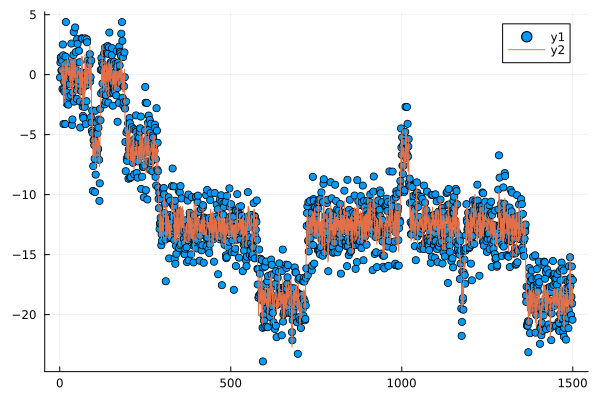

In [451]:
scatter(data)
plot!(true_state)

In [407]:
struct GPTransitionMeta{S,T,K}
    Xu          :: S
    Kuu_inverse :: T  
    Kuu         :: T
    kernel      :: K
end

GPTransitionMeta(Xu::Vector, Kuu_inverse::Matrix) = GPTransitionMeta(Xu, Kuu_inverse)
getinducinginput(meta::GPTransitionMeta) = meta.Xu 
getinverseKuu(meta::GPTransitionMeta) = meta.Kuu_inverse
getKuu(meta::GPTransitionMeta) = meta.Kuu 
getkernel(meta::GPTransitionMeta) = meta.kernel 
getparams(meta::GPTransitionMeta) = (meta.Xu, meta.Kuu, meta.Kuu_inverse)

getparams (generic function with 1 method)

In [408]:
function ReactiveMP.approximate_kernel_expectation(method::AbstractApproximationMethod, g::Function, m::Real, P::Real)

    weights = ReactiveMP.getweights(method, m, P)
    points  = ReactiveMP.getpoints(method, m, P)

    gbar = g(m) - g(m)
    foreach(zip(weights, points)) do (weight, point)
        gbar += weight * g(point)
    end

    return gbar
end

function ReactiveMP.getweights(::SphericalRadialCubature, mean::Real, variance::Real)
    d = 1
    return Base.Generator(1:(2d + 1)) do i
        return i === (2d + 1) ? 1.0 / (d + 1) : 1.0 / (2.0(d + 1))
    end
end

# function ReactiveMP.getpoints(::SphericalRadialCubature, mean::Real, variance::Real)
#     d = 5
#     L = sqrt(variance)

#     tmpbuffer = zeros(d)
#     sigma_points = Base.Generator(1:(2d + 1)) do i
#         if i === (2d + 1)
#             fill!(tmpbuffer, 0.0)
#         else
#             tmpbuffer[rem((i - 1), d) + 1] = sqrt(d + 1) * (-1)^(div(i - 1, d))
#             if i !== 1
#                 tmpbuffer[rem((i - 2), d) + 1] = 0.0
#             end
#         end
#         return tmpbuffer
#     end

#     tbuffer = zeros(d) .+ mean 
#     return Base.Generator(sigma_points) do point
#         copyto!(tbuffer, mean)
#         return mul!(tbuffer, L, point, 1.0, 1.0) # point = m + 1.0 * L * point
#     end
# end

In [409]:
#create gp transition node 
struct GPTransition end 

@node GPTransition Stochastic [ out, in, u , γ] ## out: x_t , in: x_{t-1},  u: inducing points , γ: process noise 

@rule GPTransition(:out, Marginalisation) (q_in::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    Q = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    Kuu_inverse = getinverseKuu(meta)
    Xu = getinducinginput(meta)
    kernel = getkernel(meta)
    μ_u = mean(q_u)
    kxu = (x) -> kernelmatrix(kernel, [x], Xu)
    # nsamples = 1000
    # samples = rand(StableRNG(31),q_in,nsamples)
    # Ψ1 = sum(kxu.(samples)) / nsamples 
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121), kxu, q_in)
    return NormalMeanVariance((Ψ1 * Kuu_inverse * μ_u)[1], Q)
end

@rule GPTransition(:in, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_u::MultivariateNormalDistributionsFamily,q_γ::GammaShapeRate, meta::GPTransitionMeta) = begin
    γ_bar = mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    E_logγ = mean(log,q_γ)
    kernel = getkernel(meta)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    A = (x) -> kernelmatrix(kernel,[x],[x]) .- kernelmatrix(kernel,[x],Xu) * Kuu_inverse * kernelmatrix(kernel,Xu,[x])
    B = (x) -> kernelmatrix(kernel, [x], Xu) * Kuu_inverse
    
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)

    log_backwardmess = (x) -> -0.5 * log(2π) + 0.5*E_logγ - 0.5 * γ_bar * (A(x)[1] + v_y + tr(B(x)' * B(x) *Σ_u) + (μ_y - (B(x)*μ_u)[1])^2)
    return ContinuousUnivariateLogPdf(log_backwardmess)
end


@rule GPTransition(:u, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateNormalDistributionsFamily, q_γ::GammaShapeRate,meta::GPTransitionMeta) = begin
    σ² = 1/mean(q_γ) # this is just temporary assumption, will need to add this interface for the node 
    μ_y = mean(q_out)
    Xu = getinducinginput(meta)
    Kuu = getKuu(meta)
    kernel = getkernel(meta)

    # kxu = (x) -> kernelmatrix(kernel, [x], Xu)
    # kxuux = (x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu)
    # nsamples = 1000
    # samples = rand(StableRNG(31),q_in,nsamples)
    # Ψ1 = sum(kxu.(samples)) / nsamples 
    # Ψ2 = sum(kxuux.(samples)) / nsamples
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 

    μ_u = μ_y * Kuu * cholinv(Ψ2)*Ψ1'
    Σ_u = σ² * Kuu * cholinv(Ψ2) * Kuu 
    return MvNormalMeanCovariance(vcat(μ_u...), Σ_u)
end

@rule GPTransition(:γ, Marginalisation) (q_out::UnivariateGaussianDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily,q_u::MultivariateNormalDistributionsFamily,meta::GPTransitionMeta,) = begin
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 
    # k0 = (x) -> kernelmatrix(kernel, [x], [x])
    # kxu = (x) -> kernelmatrix(kernel, [x], Xu)
    # kxuux = (x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu)
    # nsamples = 1000
    # samples = rand(StableRNG(31),q_in,nsamples)
    # Ψ0 = (sum(k0.(samples)) / nsamples)[] 
    # Ψ1 = sum(kxu.(samples)) / nsamples 
    # Ψ2 = sum(kxuux.(samples)) / nsamples + 1e-7*I
    # Ψ2_ = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 
    
    I1 = clamp(Ψ0 - tr(Kuu_inverse * Ψ2),1e-12,1e12)
    I2 = clamp(μ_y^2 + v_y -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 ), 1e-12,1e12)
    if I1 + I2 < 0
        @show I1 
        @show I2 
        @show I1 + I2
    end
    # if I1 + I2 >100
    #     @show (Ψ1 * Kuu_inverse * μ_u)[]
    #     @show tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 )
    #     @show -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 )
    # end
    return GammaShapeRate(1.5, 0.5*(I1 + I2))
end



@average_energy GPTransition (q_out::UnivariateNormalDistributionsFamily, q_in::UnivariateGaussianDistributionsFamily, q_u::MultivariateNormalDistributionsFamily, q_γ::GammaShapeRate, meta::GPTransitionMeta,) = begin
    γ_bar = mean(q_γ)
    E_logγ = mean(log,q_γ)
    μ_y, v_y = mean_var(q_out)
    μ_u, Σ_u = mean_cov(q_u)
    Xu = getinducinginput(meta)
    Kuu_inverse = getinverseKuu(meta)
    kernel = getkernel(meta)
    Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], [x]),q_in)[]
    Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, [x], Xu),q_in)
    Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), q_in) + 1e-7*I 

    I1 = Ψ0 - tr(Kuu_inverse * Ψ2)
    I2 = μ_y^2 + v_y -2*μ_y * (Ψ1 * Kuu_inverse * μ_u)[] + tr(Kuu_inverse * (Σ_u + μ_u * μ_u') * Kuu_inverse * Ψ2 )

    return 0.5*(I1*γ_bar - E_logγ + log(2π) + I2 * γ_bar) 
end

In [410]:
@model function gpssm(n,Kuu)
    y = datavar(Float64,n)
    x = randomvar(n)

    u ~ MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu)
    w ~ GammaShapeRate(0.01,0.01)
    x0 ~ NormalMeanVariance(0, 50.)
    x_prev = x0
    for i=1:n
        x[i] ~ GPTransition(x_prev,u,w) where { q = MeanField() }  #mean-field assumption
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [429]:
#create prior information about GP 
Nu = 80; #number of inducing points 
Xu = range(-25,5;length=Nu);

mean_gp = (x) -> 0
kernel_gp   =    5.1 *with_lengthscale(SEKernel(),1.) + 2*with_lengthscale(Matern52Kernel(),1.2) #+ with_lengthscale(PeriodicKernel(),3.14)

Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-7*I;
Kuu_inverse = cholinv(Kuu);

In [430]:
@meta function gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp)
    GPTransition(x,u) -> GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp)
end



gpssm_meta (generic function with 1 method)

In [431]:
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    m,v = approximate_meancov(ghcubature(121),(x) -> exp(right.logpdf(x)),left)
    return NormalMeanVariance(m,v)
end

In [432]:
#run inference 
niter = 15;

infer_result = inference(
    model = gpssm(n_train,Kuu),
    iterations = niter,
    data = (y = data_train,),
    initmarginals = (u = MvNormalMeanCovariance(zeros(size(Kuu,1)), Kuu), x = NormalMeanVariance(0,50),w = GammaShapeRate(0.01,0.01),),
    meta = gpssm_meta(Xu,Kuu_inverse,Kuu,kernel_gp),
    returnvars = (x = KeepLast(), u = KeepLast(),w = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

Inference results:
  Posteriors       | available for (w, u, x)
  Free Energy:     | Real[2108.17, 1886.88, 1801.06, 1759.21, 1738.4, 1727.52, 1721.34, 1717.51, 1715.0, 1713.28, 1712.07, 1711.2, 1710.56, 1710.08, 1709.73]


In [491]:
#get results
qu = infer_result.posteriors[:u]
qx = infer_result.posteriors[:x];
qw = infer_result.posteriors[:w]
# qβy = infer_result.posteriors[:βy];
;

In [555]:
mean(qw)

0.6651086005966018

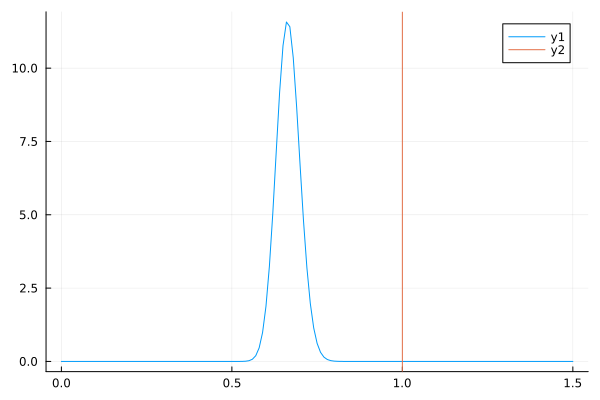

In [493]:
w_axis = collect(0:0.01:1.5)
plot(w_axis, pdf.(qw,w_axis))
vline!([1/σ_x^2])

In [494]:
true_u = transition_func.(Xu);

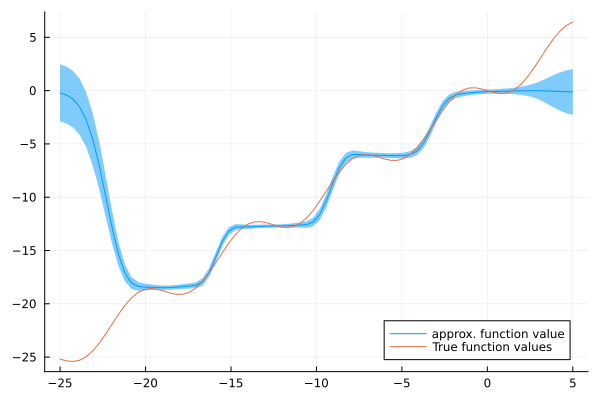

In [495]:
plot(Xu,mean(qu),ribbon = sqrt.(var(qu)),label="approx. function value")
plot!(Xu,true_u,label="True function values")

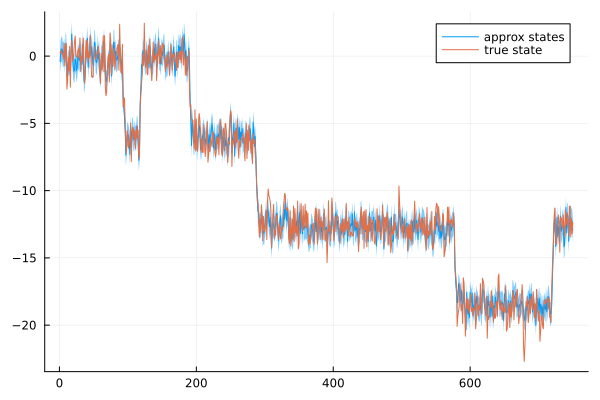

In [501]:
plot(mean.(qx), ribbon = sqrt.(var.(qx)),label="approx states")
plot!(true_state_train, label="true state")
# scatter!(data_train,label="data")


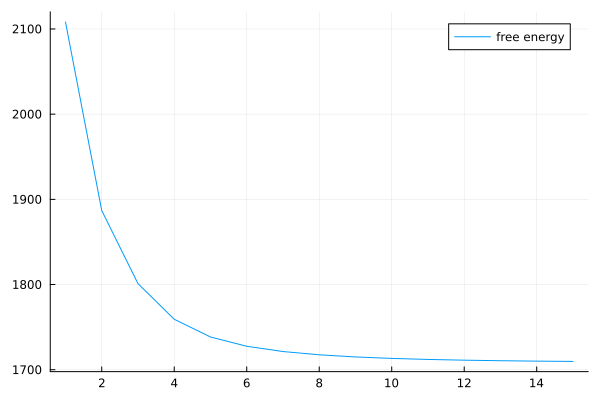

In [556]:
plot(infer_result.free_energy, label="free energy")

## Prediction

In [498]:
function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule NormalMeanVariance(:μ, Marginalisation) (m_out = PointMass(observation), m_v = PointMass(σ_y^2))
    x = ReactiveMP.prod(ProdAnalytical(), prior_prediction, likelihood_update)
    return x
end

function  PredictState(prev_state)
    return @call_rule GPTransition(:out, Marginalisation) (q_in = prev_state, q_u = qu, q_γ = qw, meta = GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp))
end

#perform 1-step-ahead update 
prev_state = qx[end]
predicted_state = []
for i=1:n_test 
    prediction = PredictState(prev_state)
    push!(predicted_state,prediction)
    prev_state = UpdateState(prediction, data_test[i])
end
;

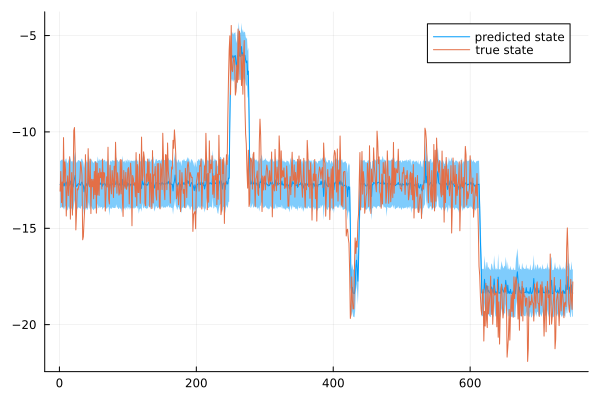

In [500]:
plot(mean.(predicted_state), ribbon = sqrt.(var.(predicted_state)), label="predicted state")
plot!(true_state_test, label="true state")
# scatter!(data_test)

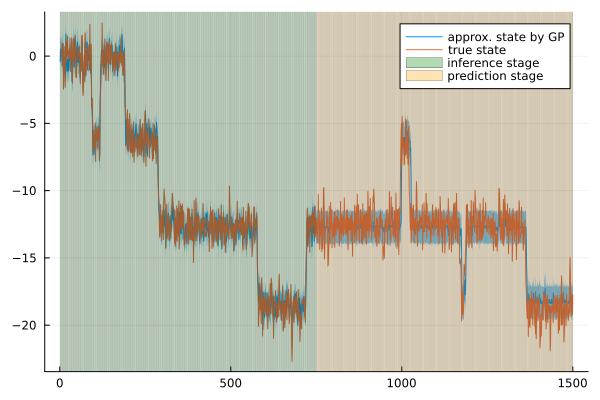

In [516]:
plot(mean.(vcat(qx,predicted_state)), ribbon = sqrt.(var.(vcat(qx,predicted_state))),label="approx. state by GP", fillrange=[751, 1500])
plot!(true_state, label ="true state")
vspan!(1:750,label="inference stage", fillalpha = 0.3, color= :green)
vspan!(751:1500,label ="prediction stage", fillalpha = 0.3, color = :orange)


## compare vs unscented

In [461]:
#unscented transform knows the exact transition function
@model function ssm_unscented(n)
    y = datavar(Float64,n)
    x = randomvar(n)
    temp_transition = randomvar(n)

    x0 ~ NormalMeanVariance(0, 50.)
    x_prev = x0
    for i=1:n
        temp_transition[i] ~ transition_func(x_prev) where { meta = Unscented(alpha=0.01) }
        x[i] ~ NormalMeanVariance(temp_transition[i],σ_x^2)
        y[i] ~ NormalMeanVariance(x[i],σ_y^2)
        x_prev = x[i]
    end
end

In [462]:
infer_result_UT = inference(
    model = ssm_unscented(n_train),
    data = (y = data_train,),
    returnvars = (x = KeepLast(),),
    free_energy = true,
    showprogress = false
) 

Inference results:
  Posteriors       | available for (x)
  Free Energy:     | Real[1500.39]


In [463]:

qx_UT = infer_result_UT.posteriors[:x]
# qw = infer_result_UT.posteriors[:w]
# qβy = infer_result_UT.posteriors[:βy];
;

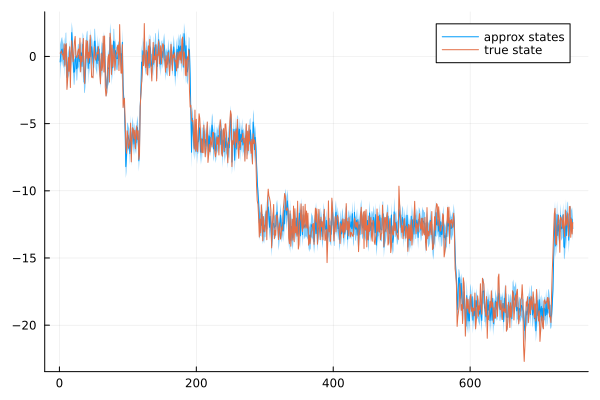

In [464]:
plot(mean.(qx_UT),ribbon=sqrt.(var.(qx_UT)), label="approx states")
plot!(true_state_train, label="true state")
# scatter!(data,label="data")

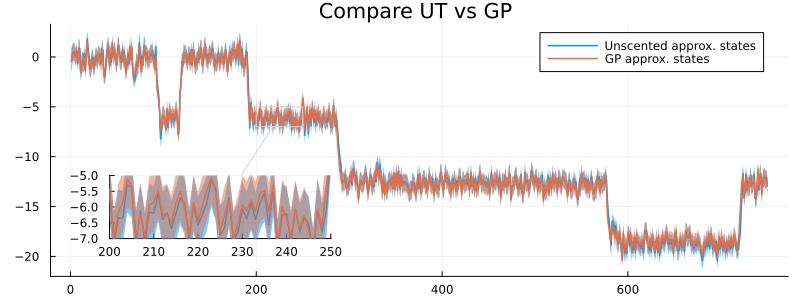

In [542]:
plot(mean.(qx_UT),ribbon=sqrt.(var.(qx_UT)), label="Unscented approx. states",lw=1.5, size = (800,300))
plot!(mean.(qx), ribbon=sqrt.(var.(qx)), label="GP approx. states",lw=1.5)
title!("Compare UT vs GP ")
lens!([200, 250], [-7, -5], inset = (1, bbox(.08, .6, 0.3, 0.25)))
# scatter!(data)


In [543]:
function prediction_UT(prev_state, func)
    m_temp, v_temp = ReactiveMP.approximate(Unscented(alpha=0.01), transition_func, (mean(prev_state),),(var(prev_state),))
    temp = NormalMeanVariance(m_temp,v_temp)
    x = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = temp, m_v = PointMass(σ_x^2))
    return x
end


prediction_UT (generic function with 1 method)

In [544]:
prev_state_UT = qx_UT[end]
predicted_state_UT = []
for i=1:n_test
    prediction = prediction_UT(prev_state_UT,transition_func)
    push!(predicted_state_UT,prediction)
    prev_state_UT = UpdateState(prediction, data_test[i])
end
;


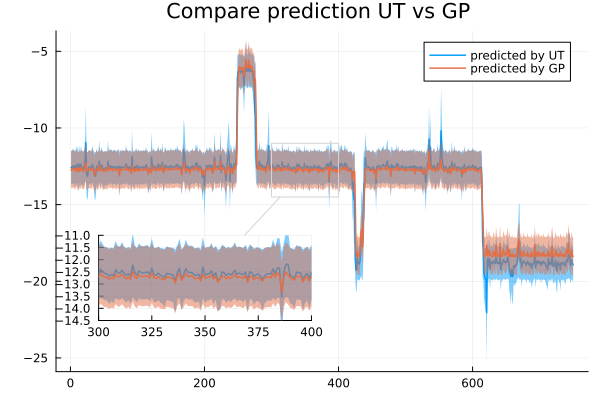

In [554]:
plot(mean.(predicted_state_UT), ribbon = sqrt.(var.(predicted_state_UT)), label = "predicted by UT", lw = 1.5)
plot!(mean.(predicted_state), ribbon = sqrt.(var.(predicted_state)), label="predicted by GP", lw = 1.5)
title!("Compare prediction UT vs GP ")
lens!([300, 400], [-14.5, -11], inset = (1, bbox(.08, .6, 0.4, 0.25)))

## store scraps

In [ ]:
# function myGDoptimizer(func, init, η; niter = 1000)
#     grad_func = let f = func 
#         (x) -> Zygote.gradient(f, x)
#     end
#     opt_val = init 
#     for i=1:niter 
#         func_prev = func(opt_val)
#         grad = grad_func(opt_val)[1]
#         opt_val = opt_val .-  η.*grad 
#         if abs(func_prev - func(opt_val)) < 1e-12
#             @show i 
#             return opt_val
#         end 
#     end
#     return opt_val
# end

# kernel_theta(θ)   =   θ[1]*with_lengthscale(SqExponentialKernel(),θ[2]) + θ[3] * with_lengthscale(Matern52Kernel(),θ[4])
# Σ_u = cov(qu)
# μ_u = mean(qu)
# D = length(μ_u)
# function nlogllh(θ)
#     Kuu = kernelmatrix(kernel_theta(θ),Xu,Xu) + Diagonal(Σ_u) + 1e-7*I
#     Kuu_inv = inv(Kuu)
#     return D/2 * log(2π) + 1/2 * log(det(Kuu)) + 1/2 * μ_u' * Kuu_inv * μ_u
# end

# θ_init = [ 5, 2,2,2]
# Zygote.gradient(nlogllh, θ_init)

# kernel_pos_gp   =    5.1 *with_lengthscale(SEKernel(),2.6) + 2*with_lengthscale(Matern52Kernel(),2.7)

# Kuu_pos = kernelmatrix(kernel_pos_gp,Xu,Xu) + 1e-7*I;
# Kuu_pos_inverse = cholinv(Kuu_pos);
# meta_pos = GPTransitionMeta(Xu,Kuu_pos_inverse,Kuu_pos,kernel_pos_gp)
# function PredictState(prev_state)
#     x = @call_rule GPTransition(:out, Marginalisation) (q_in = prev_state, q_u = qu, q_γ = qw, meta = meta_pos)
#     return x
# end

# meta_pos = GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp)
# function PredictState(prev_state)
#     x = @call_rule GPTransition(:out, Marginalisation) (q_in = prev_state, q_u = qu, q_γ = qw, meta = meta_pos)
#     return x
# end
# prev_state = qx[end]
# predicted_state = []
# for i=1:n_test
#     prediction = PredictState(prev_state)
#     push!(predicted_state,prediction)
#     prev_state = prediction
# end
# ;

# function prediction_UT(prev_state)
#     m_temp, v_temp = ReactiveMP.approximate(Unscented(alpha=0.01), transition_func, (mean(prev_state),),(var(prev_state),))
#     # temp = @call_rule DeltaFn(:out, Marginalisation) (m_ins = prev_state, meta = Unscented(alpha=0.01))
#     temp = NormalMeanVariance(m_temp,v_temp)
#     x = @call_rule NormalMeanVariance(:out, Marginalisation) (m_μ = temp, m_v = PointMass(σ_x^2))
#     return x
# end

# prev_state_UT = qx_UT[end]
# predicted_state_UT = []
# for i=1:3
#     prediction = prediction_UT(prev_state_UT)
#     push!(predicted_state_UT,prediction)
#     prev_state_UT = prediction
# end
# ;
# function PredictState(prev_state)
#     x = @call_rule GPTransition(:out, Marginalisation) (q_in = prev_state, q_u = qu, q_γ = qw, meta = GPTransitionMeta(Xu,Kuu_inverse,Kuu,kernel_gp))
#     μ_u, Σ_u = mean_cov(qu)
#     μ_w = mean(qw)
#     E_logw = mean(log,qw)
#     Ψ0 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel_gp, [x], [x]),prev_state)[]
#     Ψ1 = ReactiveMP.approximate_kernel_expectation(ghcubature(121), (x) -> kernelmatrix(kernel_gp, [x], Xu), prev_state)
#     Ψ2 = ReactiveMP.approximate_kernel_expectation(ghcubature(121),(x) -> kernelmatrix(kernel_gp, Xu, [x]) * kernelmatrix(kernel_gp, [x], Xu), prev_state) + 1e-7*I 
#     A = Ψ0 - tr(Kuu_inverse * Ψ2)
#     C = -0.5 * A * μ_w + 0.5*E_logw - 0.5 * μ_w * tr(Kuu_inverse * (μ_u * μ_u' + Σ_u) * Kuu_inverse * Ψ2) + 0.5 * μ_w * (Ψ1 * Kuu_inverse * μ_u * μ_u' * Kuu_inverse * Ψ1')[] - 0.5*log(μ_w)
    
#     E_x = mean(x) * exp(C)
#     V_x = var(x) * exp(C)
#     return x, NormalMeanVariance(E_x,V_x)
# end

#try this 
# function PredictState(prev_state)
#     μ_prev = mean(prev_state)
#     μ_new = kernelmatrix(kernel_gp,[μ_prev],Xu) * Kuu_inverse * mean(qu)
#     σ²_new = kernelmatrix(kernel_gp,[μ_prev],[μ_prev]) - kernelmatrix(kernel_gp,[μ_prev],Xu) * Kuu_inverse * kernelmatrix(kernel_gp,Xu, [μ_prev]) 
#     return NormalMeanVariance(μ_new[], mean(qw) + σ²_new[] + (kernelmatrix(kernel_gp,[μ_prev],Xu) * Kuu_inverse *cov(qu)*Kuu_inverse* kernelmatrix(kernel_gp,Xu, [μ_prev]))[])
# end